# Perform dynamic portfolio optimization with Global Data Quantum's Portfolio Optimizer

*Usage estimate: Approximately 55 minutes on ibm_torino. (NOTE: This is an estimate only. Actual runtime may vary.)*

## Background

The dynamic portfolio optimization problem aims to find the optimal investment strategy over multiple time periods to maximize the expected portfolit return and minimize risks, often under certain constraints such as budget, transaction costs, or risk aversion. Unlike standard portfolio optimization, which considers a single time to rebalance the portoflio, the dynamic version accounts for the evolving nature of assets and adapts investments based on changes in asset performance over time.

In this tutorial, we demonstrate how to perform dynamic portfolio optimization by using the Quantum Portfolio Optimizer Qiskit Function. Specifically, we illustrate how to use this application function to solve an investment allocation problem over multiple time steps.

The approach involves formulating the portfolio optimization as a multi-objective Quadratic Unconstrained Binary Optimization (QUBO) problem. Specifically, we formulate the QUBO function $O$ to simultaneously optmize four different objectives:

* Maximize the return function $F$
* Minimize the risk of the investment $R$
* Minimize the transaction costs $C$
* Comply with the investment restrictions, formulated in an additional term to minimize $P$.

In summary, to tackle these objectives we formulate the QUBO function as
$$O = -F + \frac{\gamma}{2} R + C + \rho P,$$
where $\gamma$ is the risk aversion coefficient and $\rho$ is the restrictions reinforcement coefficient (Lagrange multiplier). The explicit formulation can be found in Eq. (15) of our manuscript [\[1\]](#references).

We solve using a hybrid quantum-classical method based on the Variational Quantum Eigensolver (VQE). In this setup, the quantum circuit estimates the cost function, while the classical optimization is performed using the Differential Evolution algorithm, enabling efficient navigation of the solution landscape. The number of qubits required depends on three main factors: the number of assets ``na``, the number of time periods ``nt``, and the bit resolution used to represent the investment ``nq``. Specifically, the minimum number of qubits in our problem is `na*nt*nq`.

For this tutorial, we focus on optimizing a regional portfolio based on the Spanish IBEX 35 index. Specifically, we use a seven-asset portfolio as indicated in the table below:

| **IBEX 35 Portfolio** | ACS.MC | ITX.MC | FER.MC | ELE.MC | SCYR.MC | AENA.MC | AMS.MC |
|-----------------------|--------|--------|--------|--------|---------|---------|--------|

We rebalance our portfolio in four time steps, each separated by a 30-day interval  starting November 1, 2022. Each investment variable is encoded using two bits. This results in a problem that requires 56 qubits to solve.

We use the Optimized Real Amplitudes ansatz, a customized and hardware-efficient adaptation of the standard Real Amplitudes ansatz, specifically tailored to improve performance for this type of financial optimization problem.

Quantum execution is performed on the `ibm_torino` backend. For a detailed explanation of the problem formulation, methodology, and performance evaluation, refer to the published manuscript [\[1\]](#references).

## Requirements

In [ ]:
!pip install qiskit-ibm-catalog
!pip install pandas
!pip install matplotlib
!pip install yfinance

# Setup

To use the Quantum Portfolio Optimizer, select the function via the Qiskit Functions Catalog. You need an IBM Quantum Premium Plan or Flex Plan account with a license from Global Data Quantum to run this function.

First, authenticate with your [API key.](https://quantum.cloud.ibm.com) Then, load the desired function from the Qiskit Functions Catalog. Here, you are accessing the `quantum_portfolio_optimizer` function from the catalog by using the `QiskitFunctionsCatalog` class. This function allows us to use the predefined Quantum Portfolio Optimization solver.

In [ ]:
from qiskit_ibm_catalog import QiskitFunctionsCatalog

catalog = QiskitFunctionsCatalog(
    channel="ibm_cloud / ibm_quantum / ibm_quantum_platform",
    instance="USER_CRN / HGP",
    token="USER_API_KEY / IQP_API_TOKEN",
)
# Access function
dpo_solver = catalog.load("gdq/quantum_portfolio_optimizer")

# Step 1: Read the input portfolio

In this step, we load historical data for the seven selected assets from the IBEX 35 index, specifically from **November 1, 2022** to **April 1, 2023**.

We fetch the data by using the Yahoo Finance API, focusing on closing prices. The data is then processed to ensure that all assets have the same number of days with data. Any missing data (non-trading days) is handled appropriately, ensuring all assets are aligned on the same dates.

The data is structured in a DataFrame with consistent formatting across all assets.

In [ ]:
import yfinance as yf
import pandas as pd

# List of IBEX 35 symbols
symbols = [
    "ACS.MC",
    "ITX.MC",
    "FER.MC",
    "ELE.MC",
    "SCYR.MC",
    "AENA.MC",
    "AMS.MC",
]

start_date = "2022-11-01"
end_date = "2023-4-01"

series_list = []
symbol_names = [symbol.replace(".", "_") for symbol in symbols]

# Create a full date index including weekends
full_index = pd.date_range(start=start_date, end=end_date, freq="D")

for symbol, name in zip(symbols, symbol_names):
    print(f"Downloading data for {symbol}...")
    data = yf.download(symbol, start=start_date, end=end_date)["Close"]
    data.name = name

    # Reindex to include weekends
    data = data.reindex(full_index)

    # Fill missing values (e.g., weekends or holidays) by forward/backward fill
    data.ffill(inplace=True)
    data.bfill(inplace=True)

    series_list.append(data)

# Combine all series into a single DataFrame
df = pd.concat(series_list, axis=1)

# Convert index to string for consistency
df.index = df.index.astype(str)

# Convert DataFrame to dictionary
assets = df.to_dict()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

# Step 2: Define the problem inputs

The parameters needed to define the QUBO problem are configured in the `qubo_settings` dictionary. We define the number of time steps (`nt`), the number of bits for investment specification (`nq`), and the time window for each time step (`dt`). Additionally, we set the maximum investment per asset, the risk aversion coefficient, the transaction fee, and the restriction coefficient (see [our paper](https://arxiv.org/pdf/2412.19150) for details on the problem formulation). These settings allow us to adapt the QUBO problem to the specific investment scenario.

In [ ]:
qubo_settings = {
    "nt": 4,
    "nq": 2,
    "dt": 30,
    "max_investment": 5,  # maximum investment per asset is 2**nq/max_investment = 80%
    "risk_aversion": 1000.0,
    "transaction_fee": 0.01,
    "restriction_coeff": 1.0,
}

The `optimizer_settings` dictionary configures the optimization process, including parameters such as `num_generations` for the number of iterations and `population_size` for the number of candidate solutions per generation. Other settings control aspects like the recombination rate, parallel jobs, batch size, and mutation range. Additionally, the primitive settings, such as `estimator_shots`, `estimator_precision`, and `sampler_shots`, define the quantum estimator and sampler configurations for the optimization process.

In [ ]:
optimizer_settings = {
    "de_optimizer_settings": {
        "num_generations": 20,
        "population_size": 40,
        "recombination": 0.4,
        "max_parallel_jobs": 5,
        "max_batchsize": 4,
        "mutation_range": [0.0, 0.25],
    },
    "optimizer": "differential_evolution",
    "primitive_settings": {
        "estimator_shots": 25_000,
        "estimator_precision": None,
        "sampler_shots": 100_000,
    },
}

<Admonition type="Note">
The total number of circuits depends on the `optimizer_settings` parameters and is calculated as ``(num_generations + 1) * population_size``.
</Admonition>

The `ansatz_settings` dictionary configures the quantum circuit ansatz. The `ansatz` parameter specifies the use of the `"optimized_real_amplitudes"` approach, which is a hardware-efficient ansatz designed for financial optimization problems. Additionally, the `multiple_passmanager` setting is enabled to allow for multiple pass managers (including the default local Qiskit pass manager and the Qiskit AI-powered transpiler service) during the optimization process, improving the overall performance and efficiency of the circuit execution.

In [ ]:
ansatz_settings = {
    "ansatz": "optimized_real_amplitudes",
    "multiple_passmanager": True,
}

Finally, we execute the optimization by running the `dpo_solver.run()` function, passing in the prepared inputs. These include the asset data dictionary (`assets`), the QUBO configuration (`qubo_settings`), optimization parameters (`optimizer_settings`), and the quantum circuit ansatz settings (`ansatz_settings`). Additionally, we specify the execution details such as the backend, and whether to apply post-processing to the results. This initiates the dynamic portfolio optimization process on the selected quantum backend.

In [ ]:
dpo_job = dpo_solver.run(
    assets=assets,
    qubo_settings=qubo_settings,
    optimizer_settings=optimizer_settings,
    ansatz_settings=ansatz_settings,
    channel="<user channel>",
    instance=hub + "/" + group + "/" + project,
    backend_name="ibm_torino",
    previous_session_id=[],
    apply_postprocess=True,
)

# Step 3: Analyze the optimization results

In this section, we extract and display the solution with the lowest objective cost from the optimization results. Along with identifying the optimal state (investment trajectory), we also present key metrics associated with this solution, including the restriction deviation, Sharpe ratio, and  investment return.

In [ ]:
# Get the results of the job
dpo_result = dpo_job.result()

# Show the solution strategy
dpo_result["result"]

{'time_step_0': {'ACS.MC': 0.11764705882352941,
  'ITX.MC': 0.20588235294117646,
  'FER.MC': 0.38235294117647056,
  'ELE.MC': 0.058823529411764705,
  'SCYR.MC': 0.0,
  'AENA.MC': 0.058823529411764705,
  'AMS.MC': 0.17647058823529413},
 'time_step_1': {'ACS.MC': 0.11428571428571428,
  'ITX.MC': 0.14285714285714285,
  'FER.MC': 0.2,
  'ELE.MC': 0.02857142857142857,
  'SCYR.MC': 0.42857142857142855,
  'AENA.MC': 0.0,
  'AMS.MC': 0.08571428571428572},
 'time_step_2': {'ACS.MC': 0.0,
  'ITX.MC': 0.09375,
  'FER.MC': 0.3125,
  'ELE.MC': 0.34375,
  'SCYR.MC': 0.0,
  'AENA.MC': 0.0,
  'AMS.MC': 0.25},
 'time_step_3': {'ACS.MC': 0.3939393939393939,
  'ITX.MC': 0.09090909090909091,
  'FER.MC': 0.12121212121212122,
  'ELE.MC': 0.18181818181818182,
  'SCYR.MC': 0.0,
  'AENA.MC': 0.0,
  'AMS.MC': 0.21212121212121213}}

In [ ]:
import pandas as pd

# Get results from the job
dpo_result = dpo_job.result()

# Convert metadata to a DataFrame, excluding 'session_id'
df = pd.DataFrame(dpo_result["metadata"]["all_postprocessed_samples"])

# Find the minimum objective cost
min_cost = df["objective_costs"].min()
print(f"Minimum Objective Cost Found: {min_cost:.2f}")

# Extract the row with the lowest cost
best_row = df[df["objective_costs"] == min_cost].iloc[0]

# Display the results associated with the best solution
print("Best Solution:")
print(f"  - State: {best_row['states']}")
print(f"  - Restriction Deviation: {best_row['rest_breach']}%")
print(f"  - Sharpe Ratio: {best_row['sharpe_ratio']:.2f}")
print(f"  - Return: {best_row['return']:.2f}")

Minimum Objective Cost Found: -3.67
Best Solution:
  - State: [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
  - Restriction Deviation: 40.0%
  - Sharpe Ratio: 14.54
  - Return: 0.28


The following code shows how to visualize and compare the cost distribution of an optimization algorithm with a random sampling distribution. Similarly, we explore the landscape of the QUBO objective function (which can be loaded from the function output) by evaluating it with random investments. We plot both distributions normalized in amplitude for easier comparisson of how the optimization process differs from random sampling in terms of cost. Additionally, the result obtained using DOCPlex is included as a dashed vertical reference line to serve as a classical benchmark. We use the [free version of DOCPlex](https://ibmdecisionoptimization.github.io/docplex-doc/) — the IBM open-source library for mathematical optimization in Python — to solve the same problem classically.

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as patheffects


def plot_normalized(dpo_x, dpo_y_normalized, random_x, random_y_normalized):
    """
    Plots normalized results for two sampling results.

    Parameters:
        dpo_x (array-like): X-values for the VQE Postprocessed curve.
        dpo_y_normalized (array-like): Y-values (normalized) for the VQE Postprocessed curve.
        random_x (array-like): X-values for the Noise (Random) curve.
        random_y_normalized (array-like): Y-values (normalized) for the Noise (Random) curve.
    """
    plt.figure(figsize=(6, 3))
    plt.tick_params(axis="both", which="major", labelsize=12)

    # Define custom colors
    colors = ["#4823E8", "#9AA4AD"]

    # Plot DPO results
    (line1,) = plt.plot(
        dpo_x, dpo_y_normalized, label="VQE Postprocessed", color=colors[0]
    )
    line1.set_path_effects(
        [patheffects.withStroke(linewidth=3, foreground="white")]
    )

    # Plot Random results
    (line2,) = plt.plot(
        random_x, random_y_normalized, label="Noise (Random)", color=colors[1]
    )
    line2.set_path_effects(
        [patheffects.withStroke(linewidth=3, foreground="white")]
    )

    # Set X-axis ticks to increment by 5 units
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))

    # Axis labels and legend
    plt.xlabel("Objective cost", fontsize=14)
    plt.ylabel("Normalized Counts", fontsize=14)

    # Add DOCPLEX reference line
    plt.axvline(
        x=-4.11, color="black", linestyle="--", linewidth=1, label="DOCPlex"
    )  # DOCPlex value
    plt.ylim(bottom=0)

    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

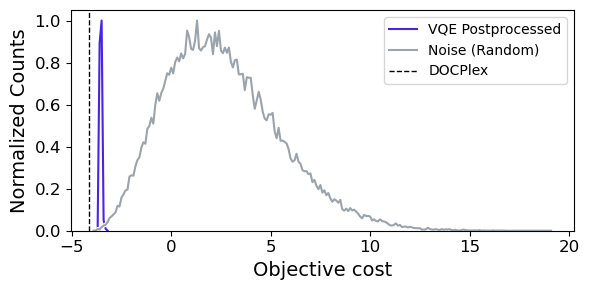

In [ ]:
import numpy as np
from collections import defaultdict

# ================================
# STEP 1: DPO COST DISTRIBUTION
# ================================

# Extract data from DPO results
counts_list = dpo_result["metadata"]["all_postprocessed_samples"][
    "objective_costs"
]  # List of how many times each solution occurred
cost_list = dpo_result["metadata"]["all_postprocessed_samples"][
    "counts"
]  # List of corresponding objective function values (costs)

# Round costs to 1 decimal and accumulate counts for each unique cost
dpo_counter = defaultdict(int)
for cost, count in zip(cost_list, counts_list):
    rounded_cost = round(cost, 1)
    dpo_counter[rounded_cost] += count

# Prepare data for plotting
dpo_x = sorted(dpo_counter.keys())  # Sorted list of cost values
dpo_y = [dpo_counter[c] for c in dpo_x]  # Corresponding counts

# Normalize the counts to the range [0, 1] for better comparison
dpo_min = min(dpo_y)
dpo_max = max(dpo_y)
dpo_y_normalized = [
    (count - dpo_min) / (dpo_max - dpo_min) for count in dpo_y
]

# ================================
# STEP 2: RANDOM COST DISTRIBUTION
# ================================

# Read the QUBO matrix
qubo = np.array(dpo_result["metadata"]["qubo"])

bitstring_length = qubo.shape[0]
num_random_samples = 100_000  # Number of random samples to generate
random_cost_counter = defaultdict(int)

# Generate random bitstrings and calculate their cost
for _ in range(num_random_samples):
    x = np.random.randint(0, 2, size=bitstring_length)
    cost = float(x @ qubo @ x.T)
    rounded_cost = round(cost, 1)
    random_cost_counter[rounded_cost] += 1

# Prepare random data for plotting
random_x = sorted(random_cost_counter.keys())
random_y = [random_cost_counter[c] for c in random_x]

# Normalize the random cost distribution
random_min = min(random_y)
random_max = max(random_y)
random_y_normalized = [
    (count - random_min) / (random_max - random_min) for count in random_y
]

# ================================
# STEP 3: PLOTTING
# ================================

plot_normalized(dpo_x, dpo_y_normalized, random_x, random_y_normalized)

The graph shows how the quantum portfolio optimizer consistently returns optimized investment strategies.

## References

[1] [Nodar, Álvaro, Irene De León, Danel Arias, Ernesto Mamedaliev, María Esperanza Molina, Manuel Martín-Cordero, Senaida Hernández-Santana et al. "Scaling the Variational Quantum Eigensolver for Dynamic Portfolio Optimization." arXiv preprint arXiv:2412.19150 (2024).](https://arxiv.org/pdf/2412.19150)

## Tutorial survey
Please take a minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.
[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_3BLFkNVEuh0QBWm)